# Assignment 1: $k$-nearest neighbors

In [1]:
import functools as ft
import typing as ty

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as RefKNeighborsClassifier
from tqdm.notebook import tqdm

np.random.seed(0x0d000721)

DPI = 200

## 1. Algorithm

```plain-text
function k_nearest_neighbors(x, samples, k, distance)
    dists <- sorted([distance(x, e) for e in samples])
    neighbors <- first k samples with closest distances
    return dominating label within neighbors
endfunction
```

In [2]:
def naive_knn(
    x: np.ndarray,
    samples: np.ndarray,
    labels: np.ndarray,
    n_labels: int,
    k: int,
) -> tuple[int, np.ndarray]:
    dists = np.linalg.norm(samples - x, ord=2, axis=1)
    kni = np.argsort(dists)[:k]
    counts = np.bincount(labels[kni], minlength=n_labels)
    return int(np.argmax(counts)), (counts / k)

## 2. Experiment setup

In [3]:
with np.load("../dataset/mnist.npz") as mnist:
    x_train, y_train = mnist["x_train"], mnist["y_train"]
    x_test, y_test = mnist["x_test"], mnist["y_test"]

x_train = x_train.reshape((x_train.shape[0], -1)).astype(np.float32) / 255.0
y_train = y_train.astype(np.intp)
x_test = x_test.reshape((x_test.shape[0], -1)).astype(np.float32) / 255.0
y_test = y_test.astype(np.intp)

print(f"x_train.shape: {x_train.shape} dtype={x_train.dtype}")
print(f"y_train.shape: {y_train.shape} dtype={y_train.dtype}")
print(f"x_test.shape: {x_test.shape} dtype={x_test.dtype}")
print(f"y_test.shape: {y_test.shape} dtype={y_test.dtype}")

n_labels = max(int(y_train.max()), int(y_test.max())) + 1
print(f"n_labels = {n_labels}")
assert n_labels == 10

x_train.shape: (60000, 784) dtype=float32
y_train.shape: (60000,) dtype=int64
x_test.shape: (10000, 784) dtype=float32
y_test.shape: (10000,) dtype=int64
n_labels = 10


## 3. Verification

We use the `KNeighborsClassifier` provided by scikit-learn as the reference implementation.

In [4]:
N_VERIF = 100

verif_samples = x_test[np.random.choice(x_test.shape[0], size=N_VERIF, replace=False)]
classifier = RefKNeighborsClassifier(n_neighbors=5, metric="minkowski", p=2)
classifier.fit(x_train, y_train)
for sample in tqdm(verif_samples):
    sample = sample[np.newaxis, :]
    pred_ref = classifier.predict(sample).squeeze(0)
    pred_ref_prob = classifier.predict_proba(sample).squeeze(0)
    pred_uut, pred_uut_prob = naive_knn(sample[0], x_train, y_train, 10, 5)
    assert pred_ref == pred_uut, f"pred_ref={pred_ref}, pred_uut={pred_uut}"
    assert np.allclose(
        pred_ref_prob, pred_uut_prob
    ), f"pred_ref_prob={pred_ref_prob}, pred_uut_prob={pred_uut_prob}"

  0%|          | 0/100 [00:00<?, ?it/s]

## 4. Evaluation

For prediction performance, we evaluate combinations of:

* Different values for $k$
* With or without feature extraction

For runtime efficiency, we evaluate how dimensionality of the sample vector influence performance.

We use the following metrics for binary prediction evaluation:

* Accuracy $C$, recall rate $R$, precision $P$
* $F_1$ score
* ROC curve and AUC

We then evaluate multi-class prediction by $R$ and $P$.

### 4.1. $k$'s influence on performance

In [5]:
c_against_k: list[tuple[int, float]] = []
for k in tqdm(range(1, 100, 2)):
    classifier = RefKNeighborsClassifier(n_neighbors=k, metric="minkowski", p=2)
    classifier.fit(x_train, y_train)
    neighbors = classifier.predict(x_test)
    correct = neighbors == y_test
    c_against_k.append((k, correct.sum() / x_test.shape[0]))

  0%|          | 0/50 [00:00<?, ?it/s]

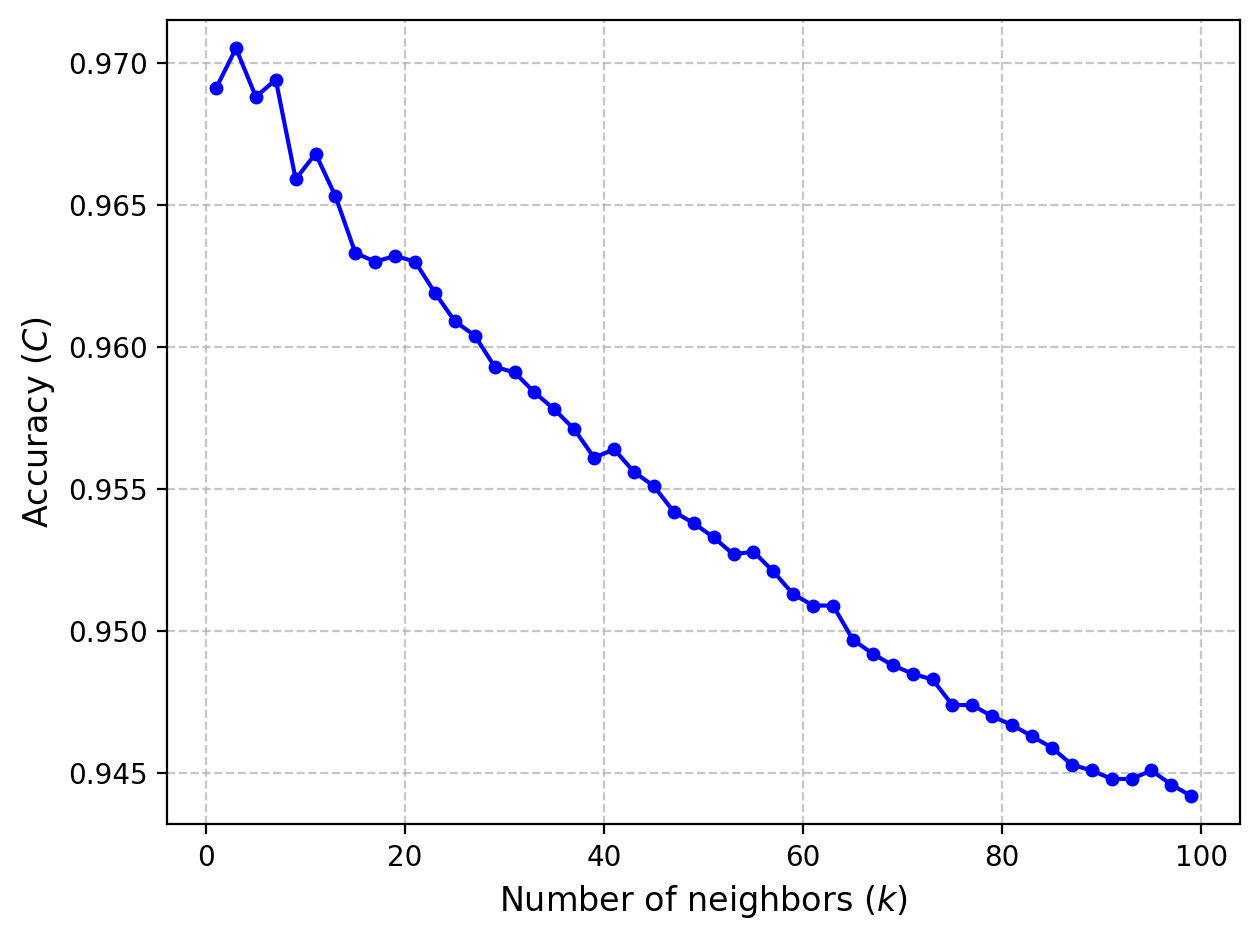

In [6]:
plt.close("all")
fig, ax = plt.subplots(dpi=DPI)
fig.canvas.header_visible = False

fac_vec = [k for k, _ in c_against_k]
c_vec = [c for _, c in c_against_k]
c_max, c_min = max(c_vec), min(c_vec)
ax.plot(fac_vec, c_vec, marker="o", linestyle="-", color="blue", markersize=4)
ax.set_ylim(top=min(1.0, c_max + 0.001), bottom=max(0.0, c_min - 0.001))
ax.set_xlabel("Number of neighbors ($k$)", fontsize=12)
ax.set_ylabel("Accuracy ($C$)", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

### 4.2. Feature extraction with PCA

We use Principal Component Analysis tool provided by scikit-learn to reduce the dimensionality of the sample vector. We use $k=3$ here.

In [7]:
K = 3

orig_n_dims = x_train.shape[1]
assert x_test.shape[1] == orig_n_dims

fac_acc: list[tuple[int, float]] = []
for fac in tqdm(range(1, 32)):
    n_dims = orig_n_dims // fac
    pca = PCA(n_components=n_dims)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)
    classifier = RefKNeighborsClassifier(n_neighbors=K, metric="minkowski", p=2)
    classifier.fit(x_train_pca, y_train)
    neighbors = classifier.predict(x_test_pca)
    correct = neighbors == y_test
    accuracy = correct.sum() / x_test.shape[0]
    fac_acc.append((fac, accuracy))

  0%|          | 0/31 [00:00<?, ?it/s]

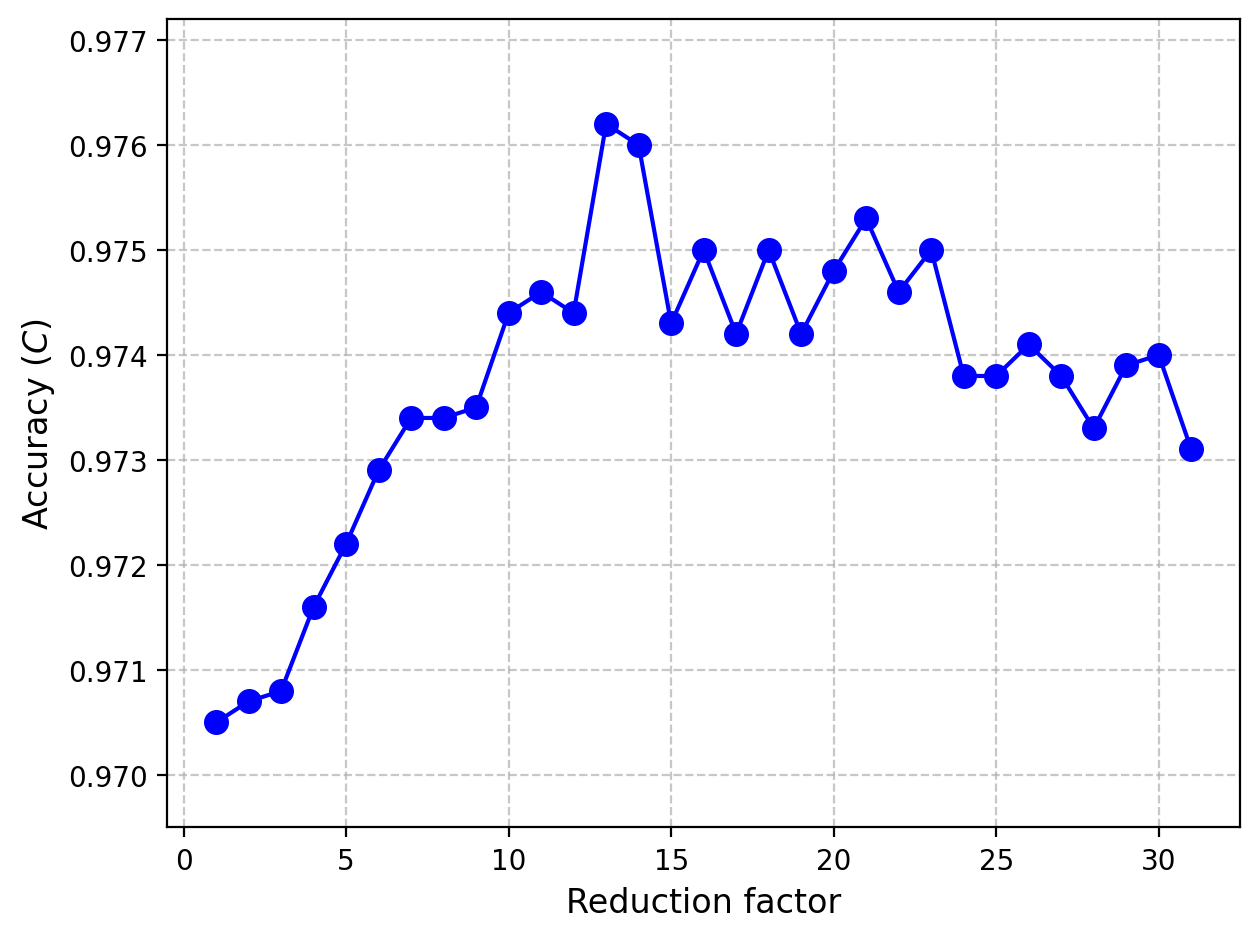

In [8]:
plt.close("all")
fig, ax = plt.subplots(dpi=DPI)
fig.canvas.header_visible = False

fac_vec = [fac for fac, _ in fac_acc]
c_vec = [c for _, c in fac_acc]
c_max, c_min = max(c_vec), min(c_vec)
ax.plot(fac_vec, c_vec, marker="o", linestyle="-", color="blue", markersize=8)
ax.set_ylim(top=min(1.0, c_max + 0.001), bottom=max(0.0, c_min - 0.001))
ax.set_xlabel("Reduction factor", fontsize=12)
ax.set_ylabel("Accuracy ($C$)", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

### 4.3. Binary prediction characteristics

We choose labels "6" and "9" for the following evaluation.

In [9]:
LABELS = (6, 9)

#### 4.3.1. $C$, $P$ and $R$ when $k=3$

In [10]:
K = 3


class BinPredEvalResult(ty.NamedTuple):
    tp: int
    fp: int
    tn: int
    fn: int

    @property
    def accuracy(self) -> float:
        return (self.tp + self.tn) / (self.tp + self.fp + self.tn + self.fn)

    @property
    def recall(self) -> float:
        return self.tp / (self.tp + self.fn) if (self.tp + self.fn) > 0 else 0.0

    @property
    def precision(self) -> float:
        return self.tp / (self.tp + self.fp) if (self.tp + self.fp) > 0 else 0.0

    @property
    def f1_score(self) -> float:
        prec = self.precision
        rec = self.recall
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0


x_train_bin = {label: x_train.copy() for label in LABELS}
y_train_bin = {label: (y_train == label).astype(y_train.dtype) for label in LABELS}
x_test_bin = {label: x_test.copy() for label in LABELS}
y_test_bin = {label: (y_test == label).astype(y_test.dtype) for label in LABELS}

In [11]:
pred_bin: dict[int, BinPredEvalResult] = {}
for label in tqdm(LABELS):
    classifier = RefKNeighborsClassifier(n_neighbors=K, metric="minkowski", p=2)
    classifier.fit(x_train_bin[label], y_train_bin[label])
    neighbors = classifier.predict(x_test_bin[label])
    correct = neighbors == y_test_bin[label]
    accuracy = correct.sum() / x_test_bin[label].shape[0]
    tp = np.logical_and(neighbors == 1, y_test_bin[label] == 1).sum()
    fp = np.logical_and(neighbors == 1, y_test_bin[label] == 0).sum()
    tn = np.logical_and(neighbors == 0, y_test_bin[label] == 0).sum()
    fn = np.logical_and(neighbors == 0, y_test_bin[label] == 1).sum()
    result = BinPredEvalResult(tp=tp, fp=fp, tn=tn, fn=fn)
    pred_bin[label] = result
    print(
        f'Label "{label}":\tC={result.accuracy:.4f}\tR={result.recall:.4f}\tP={result.precision:.4f}\tF1={result.f1_score:.4f}'
    )

  0%|          | 0/2 [00:00<?, ?it/s]

Label "6":	C=0.9970	R=0.9854	P=0.9833	F1=0.9844
Label "9":	C=0.9919	R=0.9594	P=0.9603	F1=0.9598


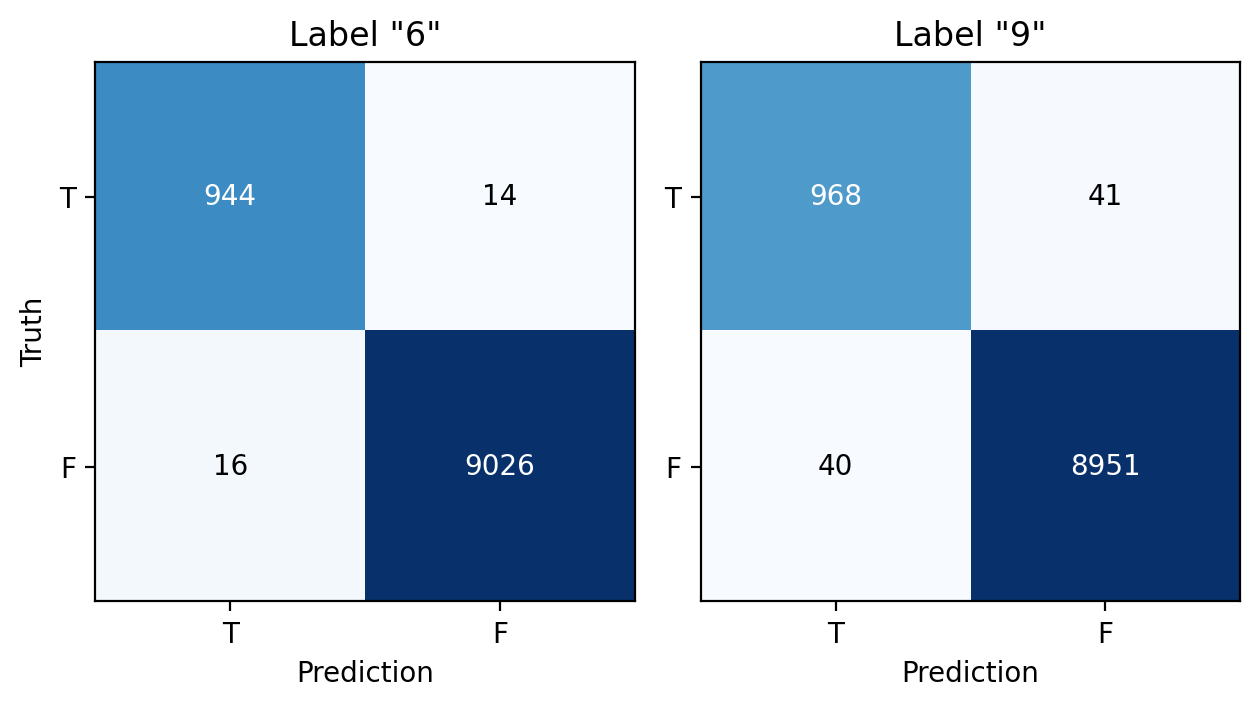

In [12]:
plt.close("all")

fig, ax = plt.subplots(1, 2, dpi=DPI)
fig.canvas.header_visible = False

for i, label in enumerate(LABELS):
    result = pred_bin[label]
    cm = np.array([[result.tp, result.fn], [result.fp, result.tn]])
    cm_scaled = np.log(cm + 1)
    im = ax[i].imshow(cm_scaled, interpolation="nearest", cmap=plt.cm.Blues)

    thresh = cm_scaled.max() / 2
    for j in range(2):
        for k in range(2):
            ax[i].text(
                k,
                j,
                f"{cm[j, k]}",
                ha="center",
                va="center",
                color="white" if cm_scaled[j, k] > thresh else "black",
            )

    ax[i].set_title(f'Label "{label}"')
    ax[i].set_xticks([0, 1])
    ax[i].set_yticks([0, 1])
    ax[i].set_xticklabels(["T", "F"])
    ax[i].set_yticklabels(["T", "F"])
    ax[i].set_xlabel("Prediction")
    if i == 0:
        ax[i].set_ylabel("Truth")

plt.tight_layout()
plt.show()

#### 4.3.2. ROC and its AUC when $k=31$

In [13]:
K = 31

conf_bin: dict[int, npt.NDArray[np.float32]] = {}
for label in tqdm(LABELS):
    classifier = RefKNeighborsClassifier(n_neighbors=K, metric="minkowski", p=2)
    classifier.fit(x_train_bin[label], y_train_bin[label])

    pred = classifier.predict(x_test_bin[label])
    neighbors = classifier.kneighbors(x_test_bin[label], return_distance=False)
    assert isinstance(neighbors, np.ndarray)
    assert neighbors.shape == (x_test_bin[label].shape[0], K)

    confidences = np.zeros((x_test_bin[label].shape[0],), dtype=np.float32)
    for i in range(x_test_bin[label].shape[0]):
        counts = np.bincount(y_train_bin[label][neighbors[i]], minlength=2)
        confidences[i] = counts[1] / K
    assert np.all(confidences >= 0.0) and np.all(confidences <= 1.0)

    conf_bin[label] = confidences

  0%|          | 0/2 [00:00<?, ?it/s]

Label 6:	AUC = 0.9981
Label 9:	AUC = 0.9976


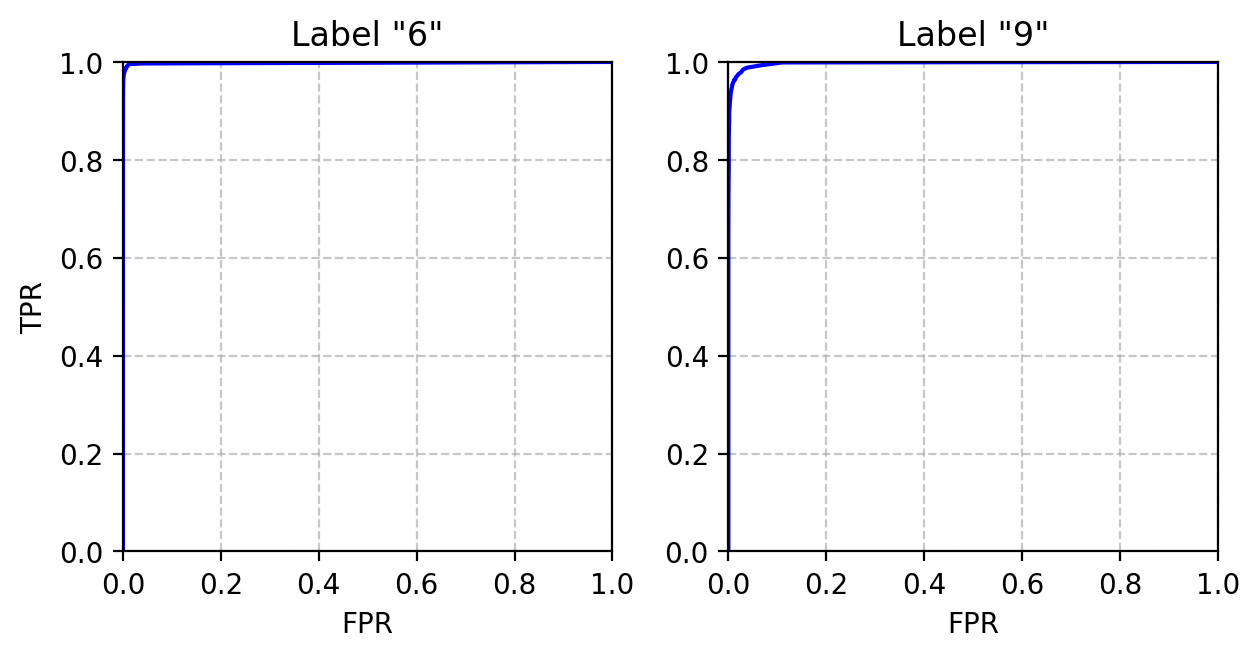

In [14]:
N_STEPS = 101

plt.close("all")

fig, ax = plt.subplots(1, 2, dpi=DPI)
fig.canvas.header_visible = False

for i, label in enumerate(LABELS):
    y_true = y_test_bin[label]
    y_scores = conf_bin[label]
    p = y_true.sum()
    n = y_true.shape[0] - p
    thresholds = np.linspace(-0.001, 1.001, num=N_STEPS, endpoint=True)
    tpr = np.zeros((N_STEPS,), dtype=np.float32)
    fpr = np.zeros((N_STEPS,), dtype=np.float32)
    for j, thr in enumerate(thresholds):
        y_pred = (y_scores >= thr).astype(y_true.dtype)
        tp = np.logical_and(y_pred == 1, y_true == 1).sum()
        fp = np.logical_and(y_pred == 1, y_true == 0).sum()
        tpr[j] = tp / p if p > 0 else 0.0
        fpr[j] = fp / n if n > 0 else 0.0

    print(f"Label {label}:\tAUC = {-np.trapezoid(tpr, fpr):.4f}")

    ax[i].plot(fpr, tpr, linestyle="-", color="blue")
    ax[i].set_title(f'Label "{label}"')
    ax[i].grid(True, linestyle="--", alpha=0.7)
    ax[i].set_xlim(left=0.0, right=1.0)
    ax[i].set_ylim(bottom=0.0, top=1.0)
    ax[i].set_xlabel("FPR")
    ax[i].set_aspect("equal", adjustable="box")
    if i == 0:
        ax[i].set_ylabel("TPR")

plt.tight_layout()
plt.show()

### 4.4. Multi-class prediction characteristics

We assume $k=3$ in this section.

In [15]:
K = 3

classifier = RefKNeighborsClassifier(n_neighbors=K, metric="minkowski", p=2)
classifier.fit(x_train, y_train)
pred_nary = classifier.predict(x_test)

cm_nary = np.zeros((n_labels, n_labels), dtype=np.int32)

for true_label, pred_label in zip(y_test, pred_nary):
    cm_nary[true_label, pred_label] += 1

for i in range(n_labels):
    tp = cm_nary[i, i]
    fp = cm_nary[:, i].sum() - tp
    fn = cm_nary[i, :].sum() - tp
    tn = cm_nary.sum() - (tp + fp + fn)
    result = BinPredEvalResult(tp=tp, fp=fp, tn=tn, fn=fn)
    print(
        f"Label {i}:\tC={result.accuracy:.4f}\tR={result.recall:.4f}\tP={result.precision:.4f}\tF1={result.f1_score:.4f}"
    )

Label 0:	C=0.9960	R=0.9939	P=0.9663	F1=0.9799
Label 1:	C=0.9948	R=0.9982	P=0.9577	F1=0.9776
Label 2:	C=0.9946	R=0.9651	P=0.9822	F1=0.9736
Label 3:	C=0.9929	R=0.9663	P=0.9635	F1=0.9649
Label 4:	C=0.9944	R=0.9674	P=0.9754	F1=0.9714
Label 5:	C=0.9937	R=0.9630	P=0.9663	F1=0.9646
Label 6:	C=0.9970	R=0.9854	P=0.9833	F1=0.9844
Label 7:	C=0.9927	R=0.9640	P=0.9649	F1=0.9645
Label 8:	C=0.9930	R=0.9384	P=0.9892	F1=0.9631
Label 9:	C=0.9919	R=0.9594	P=0.9603	F1=0.9598


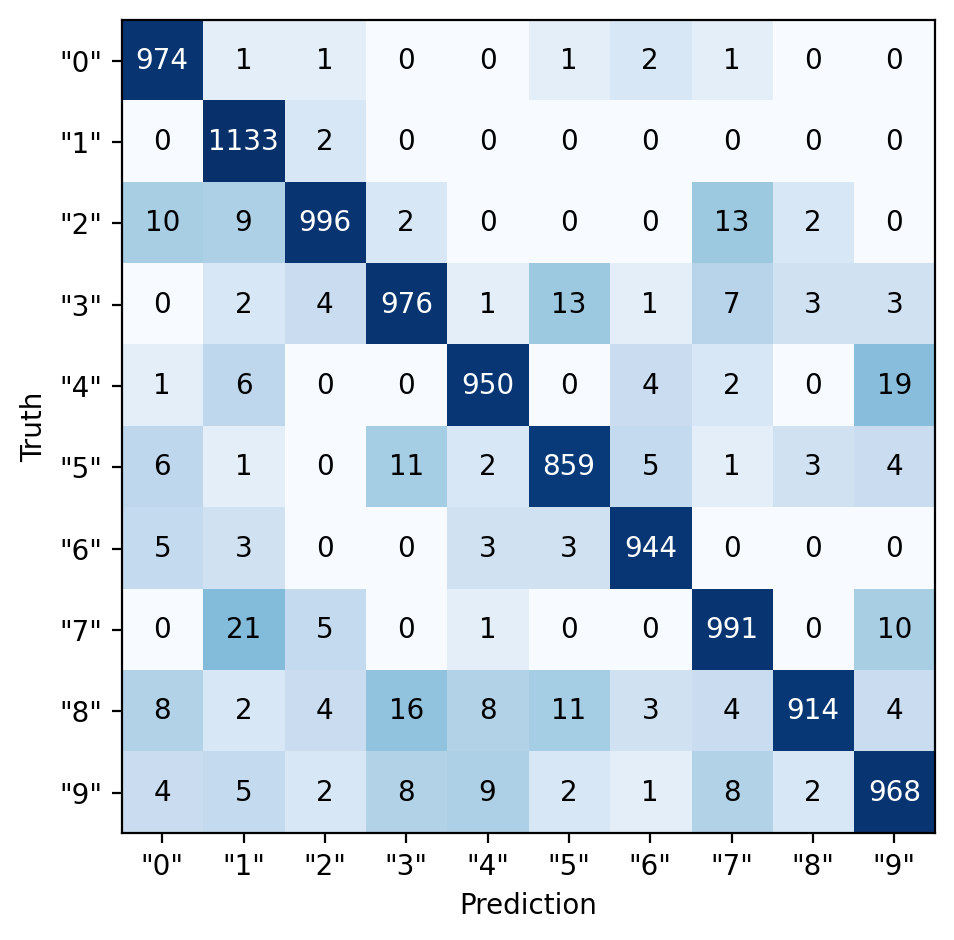

In [16]:
plt.close("all")

fig, ax = plt.subplots(dpi=DPI)
fig.canvas.header_visible = False

cm_nary_scaled = np.log(cm_nary + 1)

im = ax.imshow(cm_nary_scaled, interpolation="nearest", cmap=plt.cm.Blues)

thresh = cm_nary_scaled.max() / 2
for i in range(n_labels):
    for j in range(n_labels):
        ax.text(
            j,
            i,
            f"{cm_nary[i, j]}",
            ha="center",
            va="center",
            color="white" if cm_nary_scaled[i, j] > thresh else "black",
        )

ax.set_xticks(list(range(n_labels)))
ax.set_yticks(list(range(n_labels)))
ax.set_xticklabels([f'"{i}"' for i in range(n_labels)])
ax.set_yticklabels([f'"{i}"' for i in range(n_labels)])
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")

plt.tight_layout()
plt.show()